In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import interp2d
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import scipy.io as scio
cm=1/2.54

In [25]:
plt.rcParams['font.family']       = 'arial' # 'Times New Roman' #
# plt.rcParams['axes.linewidth']    = 1
plt.rcParams['xtick.major.size']  = 2.
plt.rcParams['ytick.major.size']  = 2.5
plt.rcParams['xtick.minor.size']  = 1.5
plt.rcParams['ytick.minor.size']  = 1.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['lines.linewidth']   = 1.5
plt.rcParams['lines.markersize']  = 3.5

plt.rcParams['font.size']    = 10
# plt.rcParams['figure.titlesize'] = 2

plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize']  = 7 # x, y label size
plt.rcParams['axes.titlesize'] = 7 # font size of the axes title
# plt.rcParams['legend.fontsize'] = 8
# plt.rcParams['legend.title_fontsize'] = 8

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams['image.cmap'] = 'jet_r'
plt.rcParams['figure.dpi'] = 150

In [26]:
res64    = scio.loadmat('../data/res64.mat')
# res64    = scio.loadmat('res64.mat')
res128   = scio.loadmat('res128.mat')
# res128   = scio.loadmat('../../Data/data/res128.mat')
# resblock = scio.loadmat('../../Data/data/resblock.mat')

In [27]:
zn_64  = res64['zn'][0]
yn_64  = res64['yn'][0]
cof_64 = res64['resitivity']
zn_128  = res128['zn'][0]
yn_128  = res128['yn'][0]
cof_128 = res128['resitivity']
# zn_block  = resblock['zn'][0]
# yn_block  = resblock['yn'][0]
# cof_block = resblock['resitivity']

In [28]:
def generate_model():

    nza = 10 # number of air layer
    n_freq = 64 # number of frequency
    size_k = 64
    z = 100e3 
    y = 100e3
    size_b = nza
    freq = np.logspace(1,np.log10(1/200),n_freq)
    # notice!
    # ry = np.linspace(-y,y,size_k)
    ry = np.linspace(-y,y,n_freq)
    multiple_t = 2.0
    multiple_b = 2.0
    multiple_l = 3.0
    multiple_r = 3.0
    z_air = -(np.logspace(0, np.log10(multiple_t*z), nza+1))[::-1]
    # near surface
    # zn0 = np.concatenate(([0],np.linspace(0.1, z, size_k)))

    #################### z in depth #######################
    # z1 = np.array([0, 2, 8, 20, 50, 120, 250, 400, 500, 700, 1000],dtype=float)
    z1 = np.array([0, 0.1, 1, 3, 6, 10, 16, 25, 40, 60, 80, \
                  100, 140, 190, 240, 300, 400, 500, 600, 800, 1000],dtype=float)
#     z1 = np.array([0,0.05, 0.1,0.5, 1, 2,3, 4.5,6, 8, 10,13, 16,20, 25,32, 40,50, 60,70, 80, 90,\
#                   100,120, 140,160, 190, 210,240,270, 300,350, 400, 450,500,550, 600,700, 800,900, 1000],dtype=float)
    n_z1 = len(z1)
    z2 = np.logspace(np.log10(1e3), np.log10(20e3), int((size_k-n_z1)/2))
    n_z2 = len(z2)
    z3 = np.logspace(np.log10(20e3),np.log10(z),size_k+3-n_z2-n_z1)
    # z4 = np.logspace(log10(100e3),log10(410e3),5)
    zn0 = np.concatenate((z1[:-1],z2[:-1],z3))
    #######################################################

    # zn0 = np.concatenate(([0],np.logspace(0.1, np.log10(z), size_k)))
    z_b = np.logspace(np.log10(zn0[-1]),np.log10(multiple_b*zn0[-1]),size_b+1)
    zn  = np.concatenate((z_air[:-1],zn0,z_b[1:]))

    yn0 = np.linspace(-y,y,size_k+1)
    # expand non kernel domain
    y_l = -(np.logspace(np.log10(multiple_l*yn0[-1]),np.log10(yn0[-1]),size_b+1))
    y_r = np.logspace(np.log10(yn0[-1]),np.log10(multiple_r*yn0[-1]),size_b+1)
    yn  = np.concatenate((y_l[:-1],yn0,y_r[1:]))

    ############## background and air layer #####################
    len_z = size_b+size_k+nza
    len_y = 2*size_b+size_k
    model = np.ones((len_z,len_y))*(2)# 100ohm.m for background
    #############  parameters  ###################################
    model[nza:-size_b,size_b:-size_b] = cof_64
    model[nza:-size_b,:size_b]  = cof_64[:,0:1]*np.ones((size_k,size_b)) # left
    model[nza:-size_b,-size_b:] = cof_64[:,-1:]*np.ones((size_k,size_b))#right
    # bottom, interpolate from bottom to expanded bottom (100 ohm.m)
    sig_bottom = np.concatenate((model[-size_b-1:-size_b,:],(2)*np.ones_like(model[-size_b-1:-size_b,:])),0).T
    f = interp2d(np.concatenate([zn0[-1:],[zn[int(-size_b/2)]]]),yn[1:], sig_bottom, kind='linear')
    model[-size_b:int(-size_b/2),:]           = f(zn[-size_b:int(-size_b/2)],yn[1:]).T
        
    model[:nza,:] = 9
    return zn, yn, freq, ry, model,zn0,yn0

In [29]:
zn0, yn0, freq, ry, model,_,_,=generate_model()

In [30]:
size_b = 10
zn_p = np.concatenate((zn0[:size_b+1],zn0[-size_b-1:]))
yn_p = np.concatenate((yn0[:size_b+1],yn0[-size_b-1:]))
Yn_p,Zn_p = np.meshgrid(yn_p,zn_p)

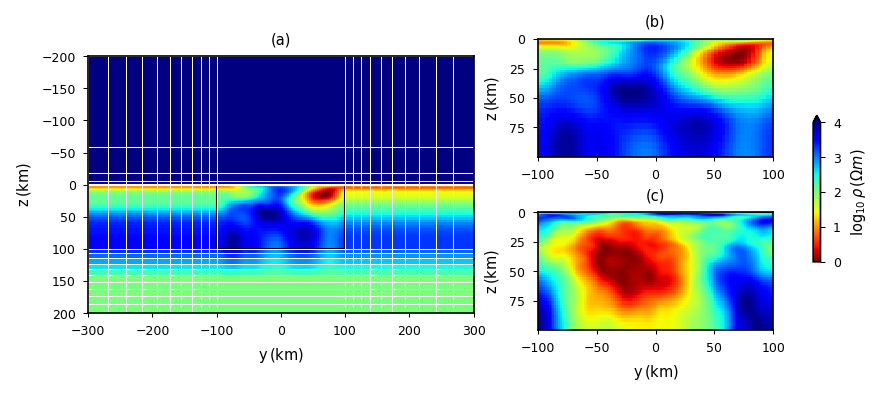

In [31]:

n_bins = 5 # number of ticks in colorbar
title_label=['(a)','(b)','(c)']
text_x_pos     = -125 # text location (value is relative to axis data in map)
text_y_pos     = -4 
rotation       = 0  # text rotation
text_size = 10
labelpad  = 10
loc = 'right'
pad = 0.1
# y_value = [0]
y_ticks = [0,25,50,75]
yn = [yn0,yn_64,yn_128,]
zn = [zn0,zn_64,zn_128,]
cof =[model,cof_64,cof_128,]

figsize  = (16*cm,7*cm)#(10*n_column,6*n_row)
fig     = plt.figure(figsize=figsize)
gs      = gridspec.GridSpec(2, 5)
ax0 = plt.subplot(gs[:, 0:3])
ax1 = plt.subplot(gs[0,3:])
ax2 = plt.subplot(gs[1,3:])
ax = [ax0,ax1,ax2]
pz=[0,100,100,0,0]
py=[-100,-100,100,100,-100]
j=0
ax[j].pcolormesh(yn[j]/1e3,zn[j]/1e3,cof[j], vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax[j].plot(py,pz,'k',linewidth=1)
# ax[j].plot(Yn_p.flatten()/1e3,Zn_p.flatten()/1e3,'w',linewidth=0.5)
segs1 = np.stack((Yn_p/1e3,Zn_p/1e3), axis=2)
segs2 = segs1.transpose(1,0,2)
ax[j].add_collection(LineCollection(segs1,color='w',linewidth=0.5))
ax[j].add_collection(LineCollection(segs2,color='w',linewidth=0.5))
ax[j].set_xlabel(r'y$\,$(km)')
ax[j].set_ylabel(r'z$\,$(km)')
ax[j].set_title(title_label[j])
ax[j].invert_yaxis()
ax[j].set_aspect(1)
for j in range(1,3):
    h=ax[j].pcolormesh(yn[j]/1e3, zn[j]/1e3, cof[j], vmin=0,vmax=4,shading='flat')#,edgecolors='k')
    ax[j].set_aspect(1)
    if j==2:
        ax[j].set_xlabel(r'y$\,$(km)')
    ax[j].set_ylabel(r'z$\,$(km)')
    ax[j].set_title(title_label[j])
#     ax[j].text(text_x_pos,text_y_pos,title_label[j], horizontalalignment='center',\
#                              verticalalignment='center',rotation=rotation,fontsize=text_size)
    ax[j].invert_yaxis()
    ax[j].set_yticks(y_ticks)
cbar = fig.colorbar(h,ax=[ax[ii] for ii in range(0,3)],location=loc,pad=pad,\
                   fraction=0.01,anchor=(0.6,0.5),extend='max'
                   )
cbar.set_label(r"$\log_{10}\,\rho\,(\Omega m)$")#,labelpad=labelpad)
cbar.ax.locator_params(nbins=n_bins)
    #         ax[i,j].set_aspect(1)
# fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.75, hspace =0.25,right=0.85,)#调整子图间距
# plt.savefig("../imags/all_resisitivity_line.jpg",dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.savefig("../imags/all_resisitivity_line.pdf",dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()


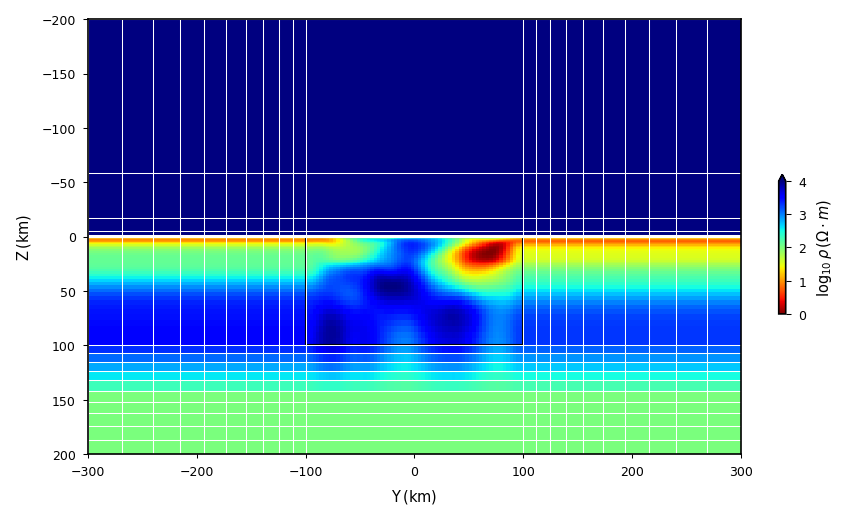

In [32]:
n_bins = 5 # number of ticks in colorbar
title_label=['(a)','(b)','(c)']
text_x_pos     = -125 # text location (value is relative to axis data in map)
text_y_pos     = -4 
rotation       = 0  # text rotation
text_size = 10
labelpad  = 10
loc = 'right'
pad = 0.1
# y_value = [0]
y_ticks = [0,25,50,75]
yn = [yn0,yn_64,yn_128,]
zn = [zn0,zn_64,zn_128,]
cof =[model,cof_64,cof_128,]

# figsize  = (16*cm,7*cm)#(10*n_column,6*n_row)
fig     = plt.figure()
gs      = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[:])
# ax1 = plt.subplot(gs[0,3:])
# ax2 = plt.subplot(gs[1,3:])
ax = [ax0]
pz=[0,100,100,0,0]
py=[-100,-100,100,100,-100]
j=0
ax[j].pcolormesh(yn[j]/1e3, zn[j]/1e3, cof[j], vmin=0,vmax=4,shading='flat')#,edgecolors='k')
ax[j].plot(py,pz,'k',linewidth=1)
# ax[j].plot(Yn_p.flatten()/1e3,Zn_p.flatten()/1e3,'w',linewidth=0.5)
segs1 = np.stack((Yn_p/1e3, Zn_p/1e3), axis=2)
segs2 = segs1.transpose(1,0,2)
ax[j].add_collection(LineCollection(segs1,color='w',linewidth=0.5))
ax[j].add_collection(LineCollection(segs2,color='w',linewidth=0.5))
ax[j].set_xlabel(r'Y$\,$(km)')
ax[j].set_ylabel(r'Z$\,$(km)')
# ax[j].set_title(title_label[j])
ax[j].invert_yaxis()
ax[j].set_aspect(1)
cbar = fig.colorbar(h,ax=[ax[ii] for ii in range(1)],location=loc,pad=pad,\
                   fraction=0.01,anchor=(0.6,0.5),extend='max'
                   )
cbar.set_label(r"$\log_{10}\,\rho\,(\Omega \cdot m)$")#,labelpad=labelpad)
cbar.ax.locator_params(nbins=n_bins)
    #         ax[i,j].set_aspect(1)
# fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0.75, hspace =0.25,right=0.85,)#调整子图间距
# plt.savefig("./figs/resisitivity_sample.pdf",bbox_inches='tight',pad_inches=0.05)
plt.show()